In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.append('..')
from single_cell_analysis.datasets import sciplex
from single_cell_analysis.ot import sinkhorn

from pathlib import Path

import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import pandas as pd
import scanpy as sc
from tqdm import tqdm

from geomloss import SamplesLoss
import torch

import ot
import ot.gpu

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


In [3]:
# change this path with the path you have sciplex dataset
data_path = Path('/home/yavuz/data/sciplex')
figures_path = Path('figures')
figures_path.mkdir(exist_ok=True)
device = torch.device('cuda')
sinkhorn_geomloss = SamplesLoss(loss="sinkhorn", scaling=0.9, p=1, debias=True).to(device)
sinkhorn_cuturi = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100).to(device)

In [118]:
def extract_sets_from_perturbations(dataset, group_by:list=['perturbation_raw']):
    set_labels = []
    set_values = []
    for group, indices in dataset.obs.groupby(group_by).indices.items():
        set_labels.append(group)
        set_values.append(dataset[indices])
    return set_labels, set_values

import math

def sinkhorn_distances_among_sets(sets, labels, sample_size=None, sample_count=None, method='emd'):
    if sample_size is not None and sample_count is not None:
        result_sets = []
        result_labels = []
        for set_idx, set in enumerate(sets):
            for i in range(sample_count):
                random_idx = np.random.randint(len(sets), size=sample_size)
                result_sets.append(set[random_idx])
                result_labels.append(labels[set_idx])
        sets = result_sets
        labels = result_labels
        
    pairs = torch.combinations(torch.arange(len(sets)), 2)    
    distance_matrix = torch.zeros((len(sets),len(sets)))
    transport_costs = np.empty((len(sets),len(sets)), dtype=object)
    for pair in tqdm(pairs):
        batch_1 = sets[pair[0]].obsm['X_pca']
        batch_2 = sets[pair[1]].obsm['X_pca']

        batch_1_len = len(batch_1)
        batch_2_len = len(batch_2)
        a, b = np.ones((batch_1_len,)) / batch_1_len, np.ones((batch_2_len,)) / batch_2_len
        C = ot.dist(batch_1, batch_2, metric='euclidean')
        if method == 'emd':
            T = ot.emd(a, b, C)
        elif method == 'sinkhorn':
            lambd = 10
            T = ot.sinkhorn(a, b, C, lambd)
#         W = ot.sinkhorn(a, b, C, lambd, verbose=True)      
#         dist, pi, C = sinkhorn(torch.from_numpy(batch_1).to(device), torch.from_numpy(batch_2).to(device))
        W = C * T
        distance_matrix[pair[1], pair[0]] = distance_matrix[pair[0], pair[1]] = W.sum()
        transport_costs[pair[1], pair[0]] = transport_costs[pair[0], pair[1]] = W
    return distance_matrix, sets, labels, transport_costs

import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_embeddings_from_distance_matrix(distance_matrix, range_=None, labels=None, title=None, n_clusters=None):
    pca_ = PCA(n_components=2)
    pca_.fit(distance_matrix.numpy())
    embeddings = pca_.transform(distance_matrix.numpy())
    # treat = np.array([c[0] for c in comb])
    # dose = np.array([c[1] for c in comb])
    # treat_dose = np.array([t + '_' + str(d) for t, d in zip(treat,dose)])
    # for t in np.unique(treat):
    if range_ is not None:
        embeddings = embeddings[range_,:]
        labels = labels[range_]

    if type(labels[0]) == str:
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
    else:
        norm = colors.LogNorm()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True))
    # sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1])
    plt.title(f'Embeddings for treatment distributions: {title}')
    plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
    
    if n_clusters is not None:
        kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
        clusters = kmeans.labels_.astype(str)
        plt.figure()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=clusters)
        plt.title(f'Embeddings for treatment distributions: {title} (KMeans)')
        plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
        return clusters
    
def add_clusters(adata, sample, n_clusters, cluster_labels):
    cluster_indices = [s.obs.index for s in sample]
    for label, index in zip(cluster_labels, cluster_indices):
        adata.obs.at[index, f'sinkhorn_cluster_{n_clusters}'] = label

In [5]:
sciplex2 = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=True).dataset

In [6]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Testing

In [7]:
set_labels, set_values = extract_sets_from_perturbations(sciplex2, group_by=['treatment'])

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
set_values

[View of AnnData object with n_obs × n_vars = 5389 × 35915
     obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
     var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 8191 × 35915
     obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
     var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_o

In [119]:
sinkhorn_matrix, set_values, set_labels, transport_costs = sinkhorn_distances_among_sets(set_values, set_labels)

  0%|          | 0/6 [00:00<?, ?it/s]/home/yavuz/miniconda3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 6/6 [00:33<00:00,  5.61s/it]


In [120]:
sinkhorn_matrix2, set_values2, set_labels2, transport_costs2 = sinkhorn_distances_among_sets(set_values, set_labels, method='sinkhorn')

100%|██████████| 6/6 [02:17<00:00, 22.99s/it]


([<matplotlib.axis.YTick at 0x7f18700f0d00>,
 [Text(0, 0, 'BMS'),
  Text(0, 1, 'Dex'),
  Text(0, 2, 'Nutlin'),
  Text(0, 3, 'SAHA')])

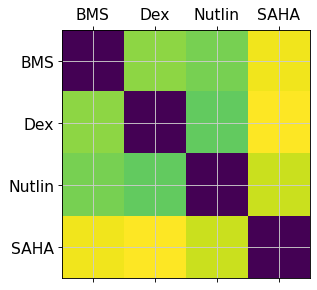

In [121]:
plt.matshow(sinkhorn_matrix)
xaxis = np.arange(len(set_labels))
plt.xticks(xaxis, set_labels)
plt.yticks(xaxis, set_labels)

([<matplotlib.axis.YTick at 0x7f18f0482910>,
 [Text(0, 0, 'BMS'),
  Text(0, 1, 'Dex'),
  Text(0, 2, 'Nutlin'),
  Text(0, 3, 'SAHA')])

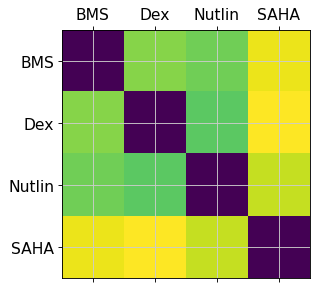

In [122]:
plt.matshow(sinkhorn_matrix2)
xaxis = np.arange(len(set_labels2))
plt.xticks(xaxis, set_labels2)
plt.yticks(xaxis, set_labels2)

In [11]:
set_labels

print(transport_costs[0][1].sum())
print(transport_costs[0][2].sum())
print(transport_costs[0][3].sum())

18.48991698159879
17.647049119112047
21.796759969442366


In [11]:
set_values[0].shape

(5389, 35915)

In [24]:
transport_costs[0][1].dtype

dtype('float64')

In [12]:
bms_dex = transport_costs[0][1].sum(axis=1)
bms_nutlin = transport_costs[0][2].sum(axis=1)
bms_saha = transport_costs[0][3].sum(axis=1)

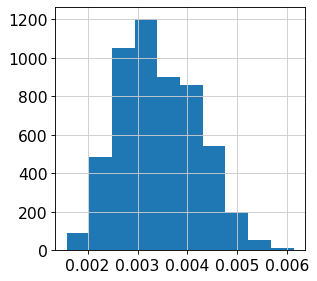

In [13]:
plt.hist(bms_dex);

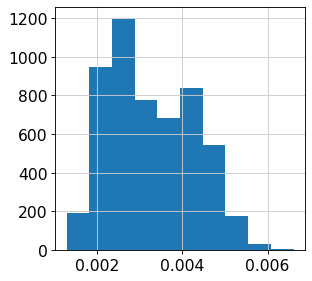

In [14]:
plt.hist(bms_nutlin);

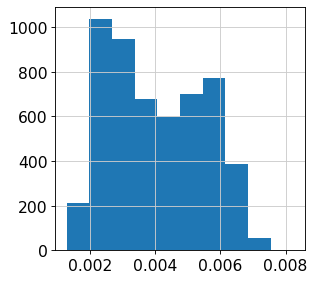

In [15]:
plt.hist(bms_saha);

In [16]:
bms_dex

array([0.00316128, 0.0035787 , 0.00263734, ..., 0.00345812, 0.00282439,
       0.00223205])

In [39]:
bms_data = np.vstack([bms_dex, bms_nutlin, bms_saha]).T

In [40]:
bms_data[0]

array([0.00316128, 0.00296432, 0.00267068])

In [43]:
bms_norm[0]

array([0.37979901, 0.3398679 , 0.28033308])

In [78]:
bms_data.min(axis=0, keepdims=True)

array([[0.00158056, 0.00129345, 0.00128799]])

In [79]:
bms_norm = (bms_data - bms_data.min(axis=0, keepdims=True)) / (bms_data.max(axis=0, keepdims=True) - bms_data.min(axis=0, keepdims=True))
bms_prob = (1-bms_norm) / (1-bms_norm).sum(axis=1, keepdims=True)

In [27]:
bms_norm2 = np.exp(-bms_data / bms_data.std())

In [85]:
bms_prob

array([[0.30489142, 0.32051626, 0.37459233],
       [0.2876204 , 0.3981323 , 0.3142473 ],
       [0.30901195, 0.33123527, 0.35975278],
       ...,
       [0.35341752, 0.3183579 , 0.32822458],
       [0.29358804, 0.34519875, 0.36121321],
       [0.33561455, 0.30383956, 0.36054589]])

In [83]:
bms_prob.max(axis=0)

array([0.76005025, 0.6383601 , 0.77310393])

In [84]:
bms_norm.min(axis=0)

array([0., 0., 0.])

In [167]:
bms_data[0] / bms_data[0].sum()

array([0.35938785, 0.33699744, 0.30361471])

In [110]:
transport_costs[0][1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

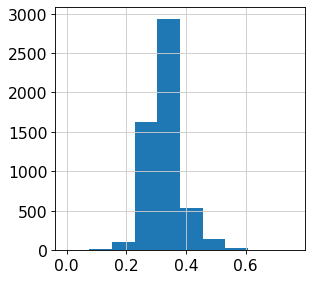

In [86]:
plt.hist(bms_prob[:,0]);

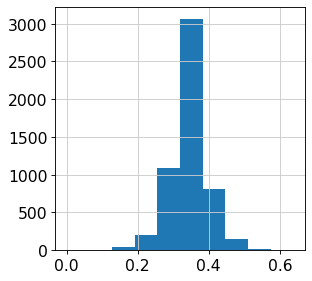

In [87]:
plt.hist(bms_prob[:,1]);

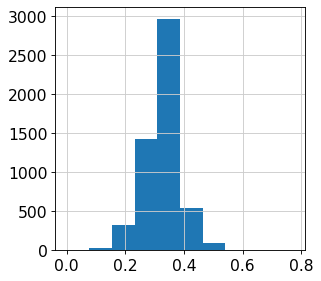

In [88]:
plt.hist(bms_prob[:,2]);

Text(0.5, 0, 'SAHA')

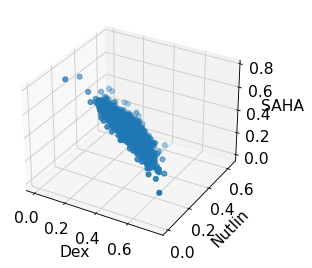

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bms_prob[:,0], bms_prob[:,1], bms_prob[:,2])
ax.set_xlabel('Dex')
ax.set_ylabel('Nutlin')
ax.set_zlabel('SAHA')

Text(0, 0.5, 'Nutlin')

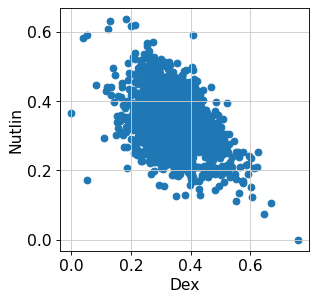

In [91]:
plt.scatter(bms_prob[:,0], bms_prob[:,1])
plt.xlabel('Dex')
plt.ylabel('Nutlin')

In [102]:
np.array([[1,0,0], [0,1,0], [0,0,1]]).shape

(3, 3)

In [100]:
bms_prob.shape

(5389, 3)

In [103]:
from sklearn.decomposition import PCA
from umap import UMAP
from phate import PHATE

data = np.vstack([bms_prob, np.array([[1,0,0], [0,1,0], [0,0,1]])])

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

umap = UMAP(n_components=2)
data_umap = umap.fit_transform(data)

phate = PHATE(n_components=2)
data_phate = phate.fit_transform(data)


In [67]:
bms_data.max(axis=0)

array([0.00612422, 0.00660664, 0.00824252])

In [108]:
bms_prob.max(axis=0)

array([0.76005025, 0.6383601 , 0.77310393])

In [95]:
bms_prob[bms_prob.argmax(axis=0)]

array([[0.76005025, 0.        , 0.23994975],
       [0.1848865 , 0.6383601 , 0.1767534 ],
       [0.05336235, 0.17353371, 0.77310393]])

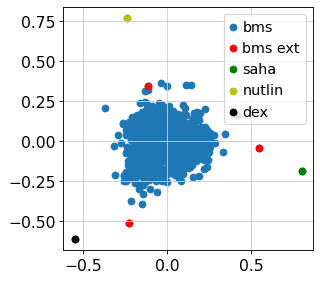

In [111]:
plt.scatter(data_pca[:,0], data_pca[:,1], label='bms')
plt.scatter(data_pca[bms_prob.argmax(axis=0),0], data_pca[bms_prob.argmax(axis=0),1], c='r', label='bms ext')
plt.scatter(data_pca[-1,0], data_pca[-1,1], c='g', label='saha')
plt.scatter(data_pca[-2,0], data_pca[-2,1], c='y', label='nutlin')
plt.scatter(data_pca[-3,0], data_pca[-3,1], c='black', label='dex')
plt.legend()